In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

Data types in 'indu' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object

Data types in 'cons' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object

Data types in 'gdp' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object


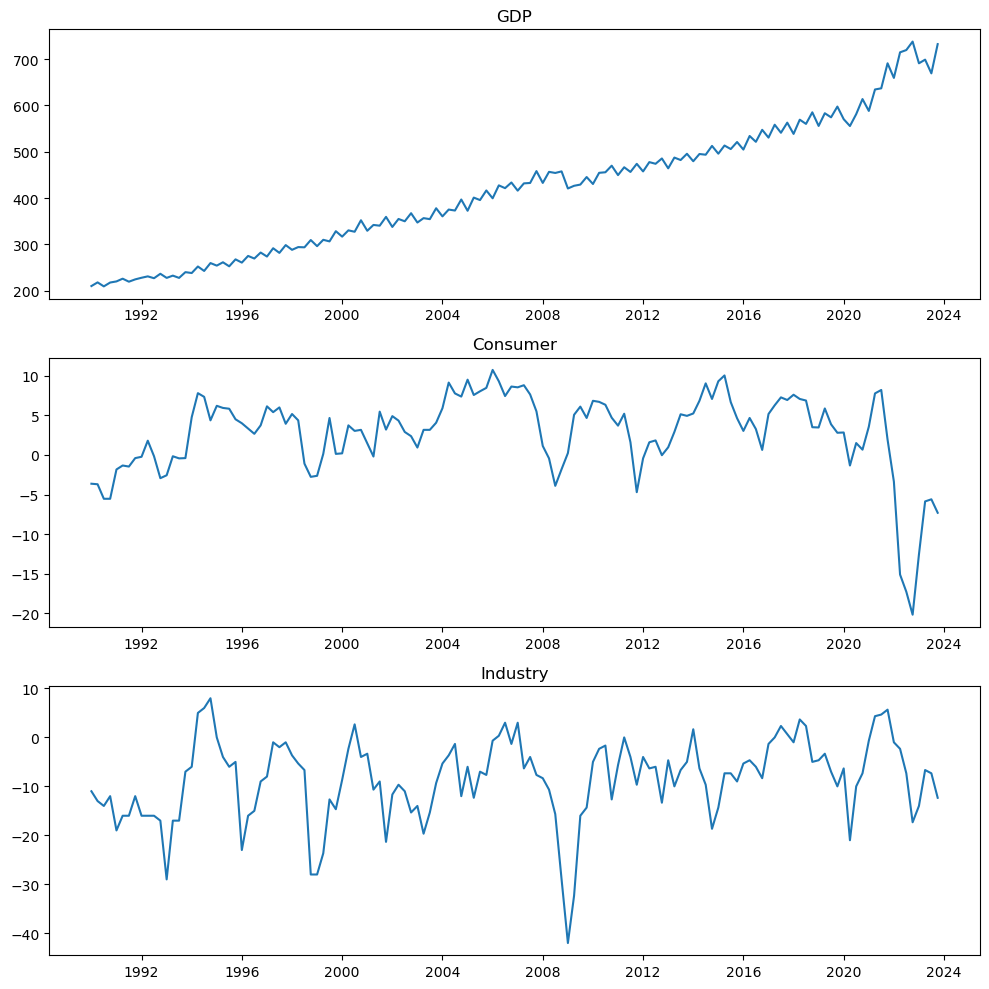

In [1]:
# Run the stored data from the Data_Preparation.ipynb
%run ..//Data_Preparation.ipynb

In [3]:
#Using the period 1990-2015 for training and 2016-2020 for testing
indu_train = indu[(indu['Time'] >= '1990-01-01') & (indu['Time'] < '2016-01-01')]
cons_train = cons[(cons['Time'] >= '1990-01-01') & (cons['Time'] < '2016-01-01')]
gdp_train = gdp[(gdp['Time'] >= '1990-01-01') & (gdp['Time'] < '2016-01-01')]

indu_test = indu[(indu['Time'] >= '2016-01-01') & (indu['Time'] < '2020-01-01')]
cons_test = cons[(cons['Time'] >= '2016-01-01') & (cons['Time'] < '2020-01-01')]
gdp_test = gdp[(gdp['Time'] >= '2016-01-01') & (gdp['Time'] < '2020-01-01')]

#Since gdp is not stationary, we will take the first difference
gdp_train['Value_diff'] = gdp_train['Value'].diff().fillna(0)

#Combine the explanatory data into one dataframe
exog_train = pd.merge(indu_train, cons_train, on='Time')
exog_train = exog_train.drop(['Time'], axis=1)

exog_test = pd.merge(indu_test, cons_test, on='Time')
exog_test = exog_test.drop(['Time'], axis=1)

#Extract the target variable
endog_train = gdp_train['Value_diff']
endog_test = gdp_test['Value']

# Define hyperparameters grid for grid search
param_grid = {
    'max_depth': [4, 5, 6],
    'min_child_weight': [5, 10, 15],
    'gamma': [0.5, 1, 1.5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


# Instantiating the XGBoost Regressor model
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Fitting the model
grid_search.fit(exog_train, endog_train)

# Getting the best parameters
best_params = grid_search.best_params_
print("Best parameters found:", best_params)

# Get the best estimator
best_xgb_reg = grid_search.best_estimator_

# Forecasting the GDP
y_pred = best_xgb_reg.predict(exog_test)

# Reversing the first difference
y_pred_norm = np.cumsum(y_pred) + gdp_test['Value'].iloc[0]

# Calculating the RMSE
rmse_value = mean_squared_error(endog_test, y_pred_norm, squared=False)

print("The RMSE of the model is:", rmse_value)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found: {'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.8}
The RMSE of the model is: 45.53865335724854


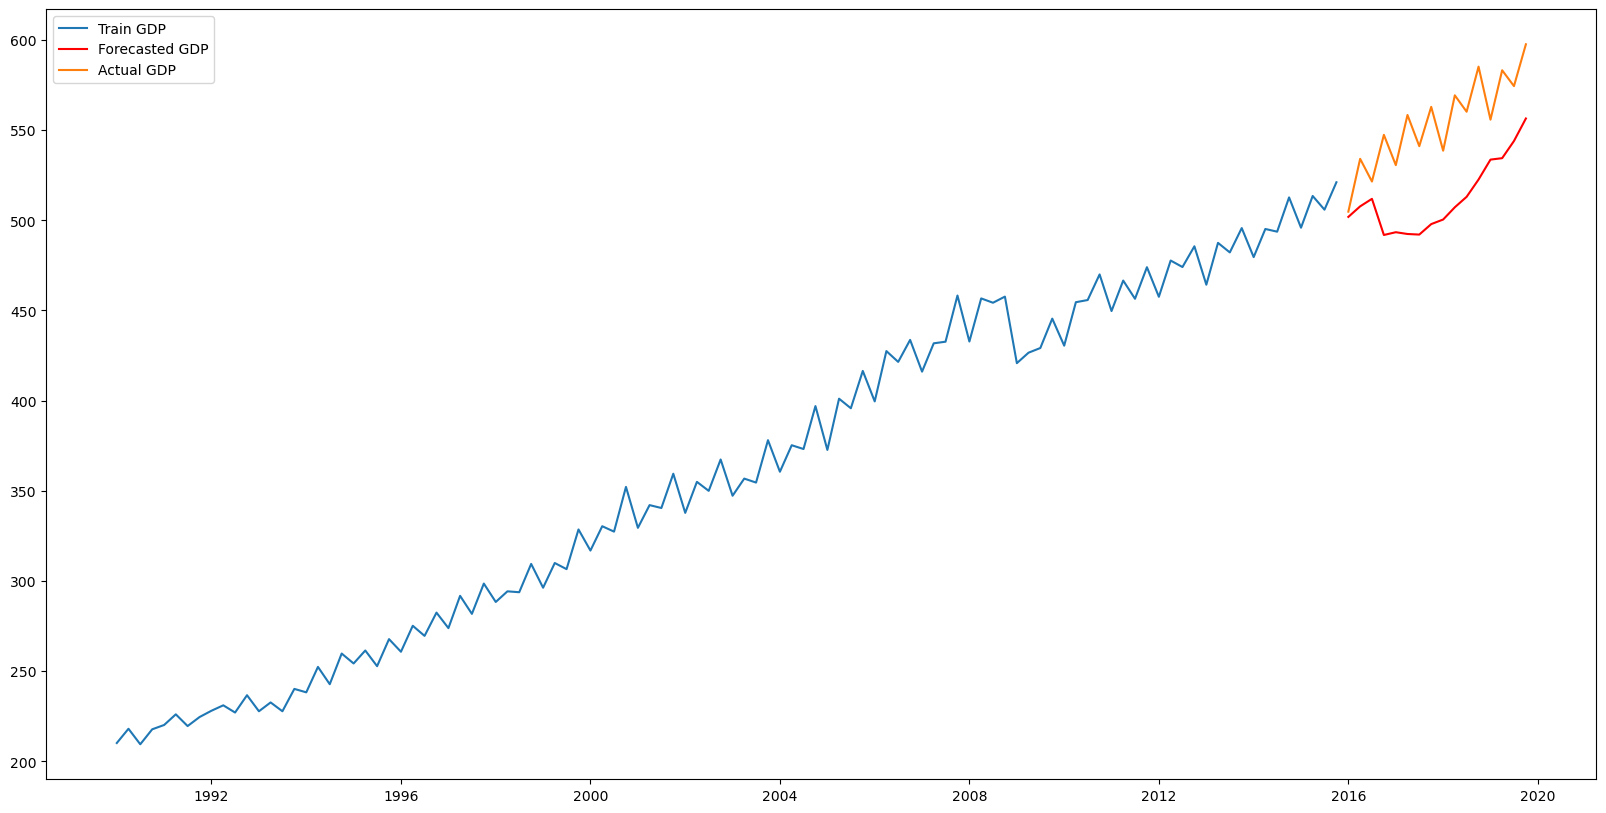

In [4]:
#Plotting the results against the actual values
plt.figure(figsize=(20,10))
plt.plot(gdp_train['Time'], gdp_train['Value'], label='Train GDP')
plt.plot(gdp_test['Time'], y_pred_norm, label='Forecasted GDP', color='red')
plt.plot(gdp_test['Time'], gdp_test['Value'], label='Actual GDP')
plt.legend(loc='upper left')
plt.show()